## Import libraries

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns

## Download and Preprocess Dataset

In [2]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)

num_classes = 10

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



## Preprocessing

In [3]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 256 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [4]:
# function for adding some more data from other classes
def put_extra_data(source_dataset_images,source_dataset_labels,target_dataset,class_num):
    for i in range(num_classes):
        if class_num != i:
            # get the indices where label == i
            temp_indices = np.asarray(np.where(source_dataset_labels == i))
            temp_indices = temp_indices.flatten()
            temp_indices = temp_indices[0:10]
            extra_images = source_dataset_images[temp_indices] # get some more negative images
            target_dataset = np.concatenate((target_dataset,extra_images))
    
    return target_dataset

def generate_labels(dataset_images,images_type):
  labels = np.zeros((dataset_images.shape[0],2))
  for i,image in enumerate(dataset_images):
    labels[i][images_type] = np.sum(dataset_images[i]) / 256
  # labels = np.full(shape=(dataset_images.shape[0],2),fill_value=[1-images_type,images_type],dtype=np.float32)
  return labels

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels which are the sum of pixel values
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    dataset_images_negative = invert(dataset_images_positive) # inverted images
    # dataset_images_negative = np.empty((0,28,28),dtype=np.float32)
    # dataset_images_negative = put_extra_data(dataset_images,dataset_labels,dataset_images_negative,class_num)
    print(dataset_images_negative.shape)

    # negative_data_indices = [i for i in range(len(dataset_labels)) if i not in indices]
    # dataset_images_negative = dataset_images[negative_data_indices]
    
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def concat_datasets(dataset1_images,dataset1_labels,dataset2_images,dataset2_labels,class_num):
    # join the two datasets
    joined_dataset_images = np.concatenate((dataset1_images,dataset2_images))
    joined_dataset_labels = np.concatenate((dataset1_labels,dataset2_labels))
    
    indices = np.asarray(np.where(joined_dataset_labels == class_num)) # indices of occurrence of class as label
    indices = indices.flatten()
    dataset_images_positive = joined_dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0)
    negative_data_indices = [i for i in range(len(joined_dataset_labels)) if i not in indices]
    
    dataset_images_negative = joined_dataset_images[negative_data_indices]
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

### Prepare the training set

In [5]:
class_num = 6
batch_size = 64
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=batch_size,shuffle=True) # take original testing set of all classes

(5918, 28, 28)
(5918, 28, 28)


### Plotting some data

tensor([[0.0000, 2.7949],
        [0.0000, 2.8086],
        [0.0000, 2.8822],
        [0.0000, 2.5518],
        [0.0000, 2.5199],
        [0.0000, 2.6821],
        [2.5650, 0.0000],
        [0.0000, 2.6943],
        [0.0000, 2.5253],
        [0.0000, 2.3983],
        [0.0000, 2.8028],
        [0.0000, 2.5663],
        [0.0000, 2.3472],
        [0.0000, 2.7278],
        [0.0000, 2.9137],
        [2.8326, 0.0000],
        [0.0000, 2.7369],
        [0.0000, 2.5187],
        [2.7043, 0.0000],
        [0.0000, 2.7173],
        [0.0000, 2.8526],
        [0.0000, 2.6385],
        [0.0000, 2.5108],
        [0.0000, 2.7483],
        [2.7200, 0.0000],
        [0.0000, 2.7340],
        [2.6041, 0.0000],
        [0.0000, 2.6348],
        [0.0000, 2.6339],
        [0.0000, 2.5344],
        [0.0000, 2.5743],
        [0.0000, 2.6118],
        [0.0000, 2.6653],
        [0.0000, 2.7421],
        [0.0000, 2.9026],
        [0.0000, 2.6436],
        [0.0000, 2.5089],
        [2.7592, 0.0000],
        [0.0

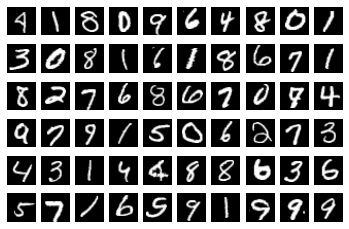

In [6]:
dataiter = iter(test_loader)
images,labels = dataiter.next()
figure = plt.figure()
print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [7]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28,100),
            nn.ReLU(),
            nn.Linear(100,10),
            nn.ReLU(),
            nn.Linear(10,2)
        )
        
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

epochs = 30
model = NeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)

# function to train the model
loss_vals = []
model.train()
for e in range(epochs):
  # epoch_loss = []
  running_loss = 0.0
  for batch, (images,logits) in enumerate(train_loader):
    optimizer.zero_grad()
    # compute prediction error
    output = model(images)
    # print(output)
    # break
    loss = criterion(output,logits)
    # loss = torch.sum(criterion(output,logits),dim=1)
    # print(loss.item())
    # break
    # Backpropagation
    loss.backward()
    optimizer.step()
    # epoch_loss.append(loss.item())
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(train_loader)}")
  # plt.plot(epoch_loss)
  # break
  


Training loss: 0.10343913234568931
Training loss: 0.003989403910708387
Training loss: 0.0023537647394413076
Training loss: 0.0020488591845826925
Training loss: 0.0018358091037166682
Training loss: 0.001661779373456296
Training loss: 0.0015157799928675632
Training loss: 0.001391355349128512
Training loss: 0.0012823845121405415
Training loss: 0.001181921033767631
Training loss: 0.0010920142018664126
Training loss: 0.0010124915861524642
Training loss: 0.0009383565032024037
Training loss: 0.0008740174865689934
Training loss: 0.0008144951913178571
Training loss: 0.0007609265623614192
Training loss: 0.0007122859794558403
Training loss: 0.0006705011282040662
Training loss: 0.0006321892340516521
Training loss: 0.0005969569420542669
Training loss: 0.0005656960285017015
Training loss: 0.0005367649711253172
Training loss: 0.0005103945917751942
Training loss: 0.00048575927755115805
Training loss: 0.00046331853923589194
Training loss: 0.0004428832181351813
Training loss: 0.00042362791136838494
Trai

## Testing

In [8]:
# for class_num in range(num_classes):
#     train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
#     test_class_set = concat_datasets(train_images,train_labels,test_images,test_labels,class_num)
#     train_loader = DataLoader(train_class_set,batch_size=64,shuffle=True)
#     test_loader = DataLoader(test_class_set,batch_size=64,shuffle=True) # take original testing set of all classes
    
#     model = NeuralNetwork()

#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(),lr = 1e-3,momentum=0.9)
#     print(f"Class Number: {class_num}")
#     train(train_loader,model,criterion,optimizer)
#     y_pred_train = test(train_loader,model)
#     y_pred_test = test(test_loader,model)
# lb = LabelBinarizer()
# lb.fit([0,1])
# binarized_labels = lb.transform(y_pred_test)
# binarized_labels = np.hstack((binarized_labels,1-binarized_labels))
# print(binarized_labels)

# function to test the model on a given threshold
def test(dataloader,model,threshold):
  size = len(dataloader.dataset)
  model.eval()
  accuracy = 0
  y_true = [] # store the true class
  y_pred = [] # store the predicted class
  y_pred_score = []
  y_true_score = []
  with torch.no_grad():
      for images,logits in dataloader:
        output = model(images)
        outnp = output.numpy()
        logit_np = logits.numpy()
        for i in range(len(outnp)):
          true_label = 1 if logit_np[i][0] > logit_np[i][1] else 0 # true class
          y_true.append(true_label)
          y_true_score.append(logit_np[i][0]) # true yes score
          y_pred_score.append(outnp[i][0]) # predicted yes score
          if outnp[i][0] >= threshold:
            y_pred.append(1) # predicted positive class
          else:
            y_pred.append(0) # predicted negative class
  accuracy = accuracy_score(y_true,y_pred) # calculate the accuracy
  precision = precision_score(y_true,y_pred) # calculate precision
  recall = recall_score(y_true,y_pred) # calculate recall



  # tp = 0.0
  # fp = 0.0
  # tn = 0.0
  # fn = 0.0
  # for i in range(len(y_true)):
  #   if y_true[i] == 1 and y_pred[i] == 1:
  #     tp += 1
  #   elif y_true[i] == 0 and y_pred[i] == 1:
  #     fp += 1
  #   elif y_true[i] == 1 and y_pred[i] == 0:
  #     fn += 1
  #   else:
  #     tn += 1
  # if tp == 0 and fp == 0:
  #   print(threshold)
  # precision = tp / (tp + fp)
  # np.savetxt("y_pred_score.txt",y_pred_score,delimiter=",")
  # np.savetxt("y_true_score.txt",y_true_score,delimiter=",")
  # print(tp,fp,tn,fn,sep=" ")
  # print(f"Accuracy : {(100*correct):>0.1f}%")
  return (accuracy,precision,recall)

# scores = np.empty((0,3),dtype=np.float32)
data = np.empty((0,4),dtype=np.float32)

yes_scores = np.linspace(0.0,3.0,31,endpoint=True)
print(yes_scores)
for threshold in yes_scores:
  accuracy,precision,recall = test(test_loader,model,threshold)
  data = np.vstack((data,[[threshold,accuracy,precision,recall]]))
  break

data
# y = [3]
# np.savetxt("y_pred_score",y,delimiter=",")
  # np.savetxt("y_true_score",y,delimiter=",")
# df = pd.DataFrame(data)
# df.columns = ['threshold','accuracy','precision','recall']
# df
# with torch.no_grad():
#     for images,logits in test_loader:
#       output = model(images)
#       output = output.numpy()
#       logits = logits.numpy()
#       for i in range(len(output)):
#         yes_score = output[i][0]
#         no_score = output[i][1]
#         # print(no_score)
#         true_label =  1 if np.argmax(logits[i]) == 0 else 0 
#         # if true_label == 0:
#         scores = np.vstack((scores,[[yes_score,no_score,true_label]]))
#       # break
# # print(scores)

# df = pd.DataFrame(scores)
# df.columns = ['yes_score','no_score','true_label']
# df

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ]
6876.0 63124.0 0.0 0.0


array([[0.        , 0.09822857, 0.09822857, 1.        ]])

### Plotting the probability scores

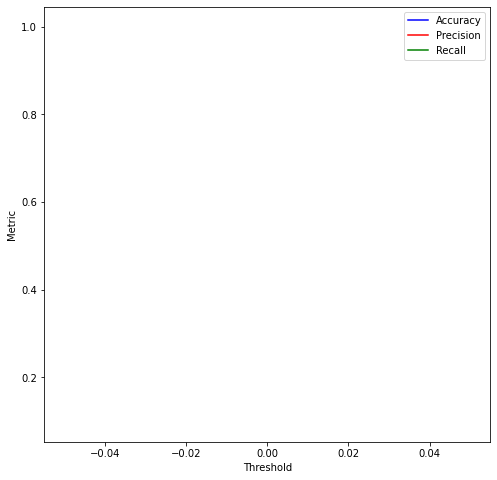

In [9]:

# print(df.describe())
# sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score",alpha=1).add_legend()
plt.figure(figsize=(8,8))
plt.plot(data[:,0],data[:,1],c='b',label='Accuracy')
plt.plot(data[:,0],data[:,2],c='r',label='Precision')
plt.plot(data[:,0],data[:,3],c='g',label='Recall')
plt.legend()
plt.ylabel("Metric")
plt.xlabel("Threshold")
plt.show()

In [10]:
# plt.scatter(np.log(scores[:,0]),np.log(scores[:,1]))